# Multivariate Gaussian Random Walk
:::{post} Feb 2, 2023
:tags: linear model, regression, time series 
:category: beginner
:author: Lorenzo Itoniazzi, Chris Fonnesbeck
:::

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor

from scipy.linalg import cholesky

%matplotlib inline

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

This notebook shows how to [fit a correlated time series](https://en.wikipedia.org/wiki/Curve_fitting) using multivariate [Gaussian random walks](https://en.wikipedia.org/wiki/Random_walk#Gaussian_random_walk) (GRWs). In particular, we perform a Bayesian [regression](https://en.wikipedia.org/wiki/Regression_analysis) of the time series data against a model dependent on GRWs.

We generate data as the 3-dimensional time series

$$
\mathbf y = \alpha_{i[\mathbf t]} +\beta_{i[\mathbf t]} *\frac{\mathbf t}{300} +\xi_{\mathbf t},\quad \mathbf t = [0,1,...,299], 
$$ (eqn:model)

where 
- $i\mapsto\alpha_{i}$ and $i\mapsto\beta_{i}$, $i\in\{0,1,2,3,4\}$, are two 3-dimensional Gaussian random walks for two correlation matrices $\Sigma_\alpha$ and $\Sigma_\beta$,
- we define the index 
$$
i[t]= j\quad\text{for}\quad t = 60j,60j+1,...,60j+59, \quad\text{and}\quad j = 0,1,2,3,4,
$$ 
- $*$ means that we multiply the $j$-th column of the $3\times300$ matrix with the $j$-th entry of the vector for each $j=0,1,...,299$, and 
- $\xi_{\mathbf t}$ is a $3\times300$ matrix with iid normal entries $N(0,\sigma^2)$.


So the series $\mathbf y$ changes due to the GRW $\alpha$ in five occasions, namely steps $0,60,120,180,240$. Meanwhile  $\mathbf y$ changes at steps $1,60,120,180,240$ due to the increments of the GRW $\beta$ and  at every step  due to the weighting of  $\beta$ with $\mathbf t/300$. Intuitively, we have a noisy ($\xi$) system that is shocked five times over a period of 300 steps, but the impact of the $\beta$ shocks gradually becomes more significant at every step. 

## Data generation

Let's generate and plot the data.

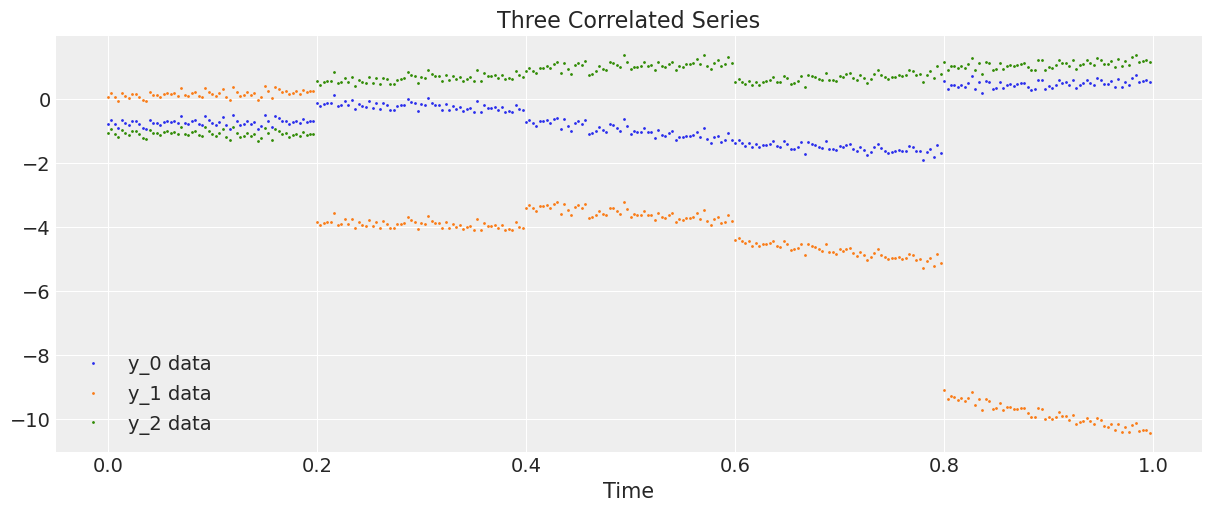

In [3]:
D = 3  # Dimension of random walks
N = 300  # Number of steps
sections = 5  # Number of sections
period = N / sections  # Number steps in each section

Sigma_alpha = rng.standard_normal((D, D))
Sigma_alpha = Sigma_alpha.T.dot(Sigma_alpha)  # Construct covariance matrix for alpha
L_alpha = cholesky(Sigma_alpha, lower=True)  # Obtain its Cholesky decomposition

Sigma_beta = rng.standard_normal((D, D))
Sigma_beta = Sigma_beta.T.dot(Sigma_beta)  # Construct covariance matrix for beta
L_beta = cholesky(Sigma_beta, lower=True)  # Obtain its Cholesky decomposition

# Gaussian random walks:
alpha = np.cumsum(L_alpha.dot(rng.standard_normal((D, sections))), axis=1).T
beta = np.cumsum(L_beta.dot(rng.standard_normal((D, sections))), axis=1).T
t = np.arange(N)[:, None] / N
alpha = np.repeat(alpha, period, axis=0)
beta = np.repeat(beta, period, axis=0)
# Correlated series
sigma = 0.1
y = alpha + beta * t + sigma * rng.standard_normal((N, 1))

# Plot the correlated series
plt.figure(figsize=(12, 5))
plt.plot(t, y, ".", markersize=2, label=("y_0 data", "y_1 data", "y_2 data"))
plt.title("Three Correlated Series")
plt.xlabel("Time")
plt.legend()
plt.show();

## Model
First we introduce a scaling class to rescale our data and the time parameter before the sampling and then rescale the predictions to match the unscaled data.

In [4]:
class Scaler:
    def __init__(self):
        mean_ = None
        std_ = None

    def transform(self, x):
        return (x - self.mean_) / self.std_

    def fit_transform(self, x):
        self.mean_ = x.mean(axis=0)
        self.std_ = x.std(axis=0)
        return self.transform(x)

    def inverse_transform(self, x):
        return x * self.std_ + self.mean_

We now construct the regression model in {eq}`eqn:model` imposing priors on the GRWs $\alpha$ and $\beta$, on the standard deviation $\sigma$ and hyperpriors on the Cholesky matrices. We use the LKJ prior {cite:p}`lewandowski2009generating` for the Cholesky matrices (see this {func}`link for the documentation <pymc.distributions.multivariate.LKJCholeskyCov>` and also the PyMC notebook {doc}`/case_studies/LKJ` for some usage examples.)

In [5]:
def inference(t, y, sections, n_samples=100):
    N, D = y.shape

    # Standardize y and t
    y_scaler = Scaler()
    t_scaler = Scaler()
    y = y_scaler.fit_transform(y)
    t = t_scaler.fit_transform(t)
    # Create a section index
    t_section = np.repeat(np.arange(sections), N / sections)

    # Create PyTensor equivalent
    t_t = pytensor.shared(np.repeat(t, D, axis=1))
    y_t = pytensor.shared(y)
    t_section_t = pytensor.shared(t_section)

    coords = {"y_": ["y_0", "y_1", "y_2"], "steps": np.arange(N)}
    with pm.Model(coords=coords) as model:
        # Hyperpriors on Cholesky matrices
        chol_alpha, *_ = pm.LKJCholeskyCov(
            "chol_cov_alpha", n=D, eta=2, sd_dist=pm.HalfCauchy.dist(2.5), compute_corr=True
        )
        chol_beta, *_ = pm.LKJCholeskyCov(
            "chol_cov_beta", n=D, eta=2, sd_dist=pm.HalfCauchy.dist(2.5), compute_corr=True
        )

        # Priors on Gaussian random walks
        alpha = pm.MvGaussianRandomWalk(
            "alpha", mu=np.zeros(D), chol=chol_alpha, shape=(sections, D)
        )
        beta = pm.MvGaussianRandomWalk("beta", mu=np.zeros(D), chol=chol_beta, shape=(sections, D))

        # Deterministic construction of the correlated random walk
        alpha_r = alpha[t_section_t]
        beta_r = beta[t_section_t]
        regression = alpha_r + beta_r * t_t

        # Prior on noise ξ
        sigma = pm.HalfNormal("sigma", 1.0)

        # Likelihood
        likelihood = pm.Normal("y", mu=regression, sigma=sigma, observed=y_t, dims=("steps", "y_"))

        # MCMC sampling
        trace = pm.sample(n_samples, tune=1000, chains=4, target_accept=0.9)

        # Posterior predictive sampling
        pm.sample_posterior_predictive(trace, extend_inferencedata=True)

    return trace, y_scaler, t_scaler, t_section

## Inference
We now sample from our model and we return the trace, the scaling functions for space and time and the scaled time index.

In [6]:
trace, y_scaler, t_scaler, t_section = inference(t, y, sections)

/home/cfonnesbeck/GitHub/pymc/pymc/distributions/timeseries.py:356: UserWarning: Initial distribution not specified, defaulting to `MvNormal.dist(0, I*100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
/home/cfonnesbeck/GitHub/pymc/pymc/distributions/timeseries.py:356: UserWarning: Initial distribution not specified, defaulting to `MvNormal.dist(0, I*100)`.You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_cov_alpha, chol_cov_beta, alpha, beta, sigma]


We now display the energy plot using {func}`arviz.plot_energy` for a visual check for the model's convergence. Then, using {func}`arviz.plot_ppc`,  we plot the distribution of the {doc}`posterior predictive samples </diagnostics_and_criticism/posterior_predictive>` against the observed data $\mathbf y$. This plot provides a general idea of the accuracy of the model (note that the values of $\mathbf y$ actually correspond to the scaled version of $\mathbf y$).

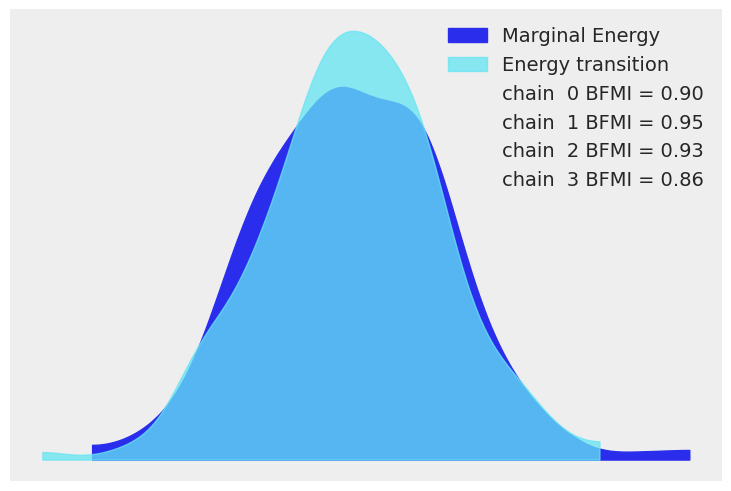

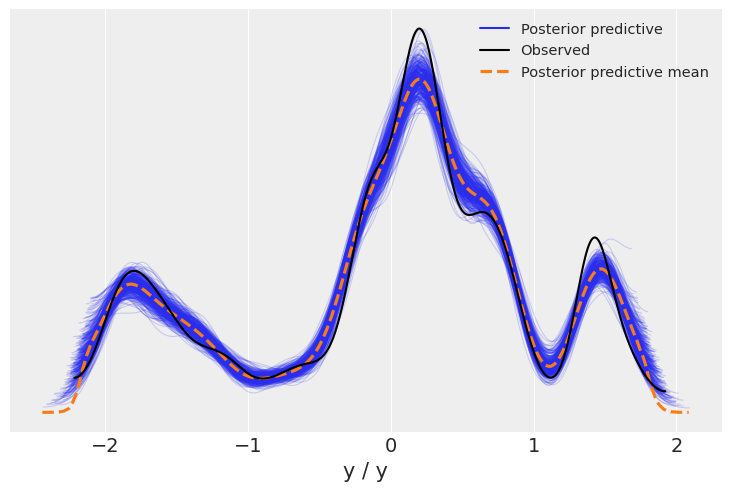

In [ ]:
az.plot_energy(trace)
az.plot_ppc(trace);

## Posterior visualisation
The graphs above look good. Now we plot the observed 3-dimensional series against the average predicted 3-dimensional series, or in other words, we plot the data against the estimated regression curve from the model {eq}`eqn:model`.

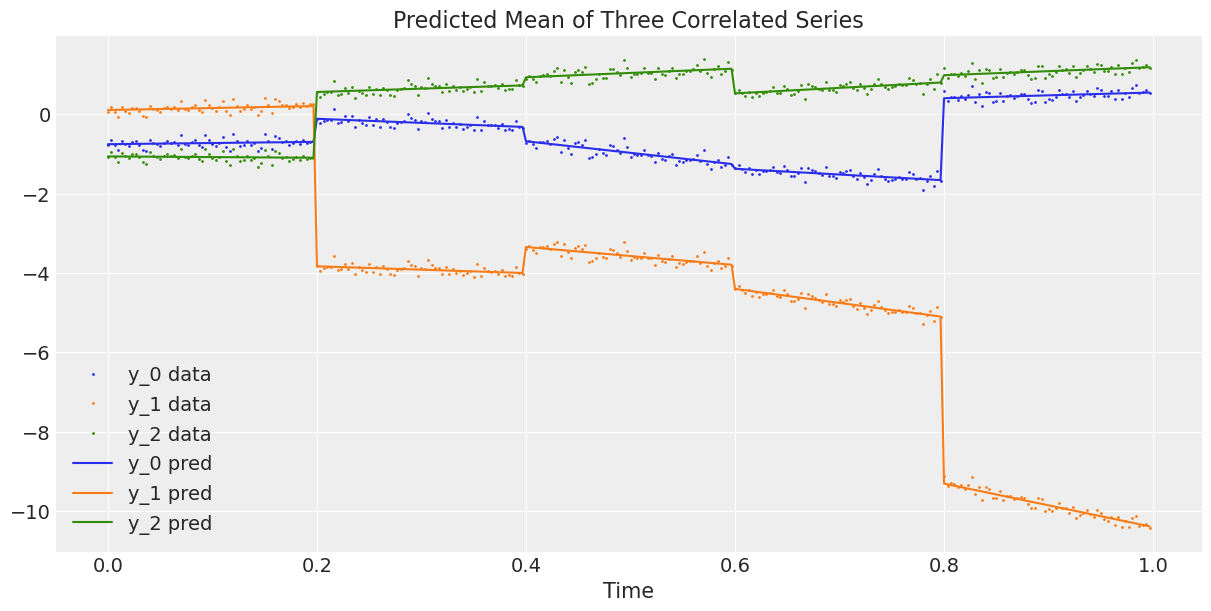

In [ ]:
# Compute the predicted mean of the multivariate GRWs
alpha_mean = trace.posterior["alpha"].mean(dim=("chain", "draw"))
beta_mean = trace.posterior["beta"].mean(dim=("chain", "draw"))

# Compute the predicted mean of the correlated series
y_pred = y_scaler.inverse_transform(
    alpha_mean[t_section].values + beta_mean[t_section].values * t_scaler.transform(t)
)

# Plot the predicted mean
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(t, y, ".", markersize=2, label=("y_0 data", "y_1 data", "y_2 data"))
plt.gca().set_prop_cycle(None)
ax.plot(t, y_pred, label=("y_0 pred", "y_1 pred", "y_2 pred"))
ax.set_xlabel("Time")
ax.legend()
ax.set_title("Predicted Mean of Three Correlated Series");

Finally, we plot the data against the posterior predictive samples.

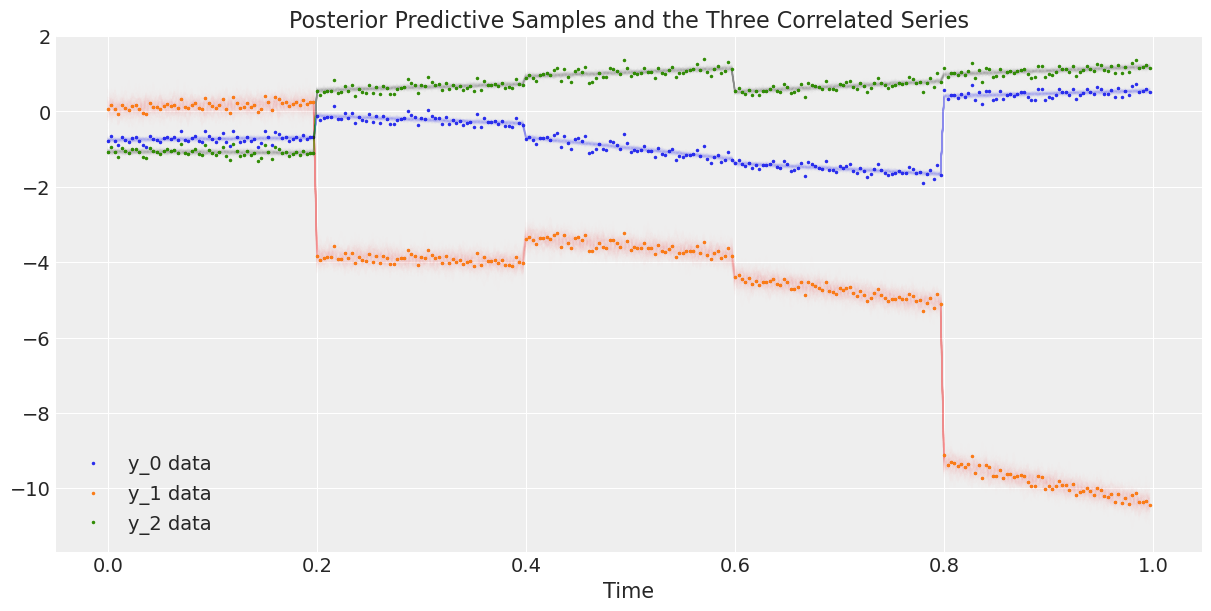

In [ ]:
# Rescale the posterior predictive samples
ppc_y = y_scaler.inverse_transform(trace.posterior_predictive["y"].mean("chain"))

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
# Plot the data
ax.plot(t, y, ".", markersize=3, label=("y_0 data", "y_1 data", "y_2 data"))
# Plot the posterior predictive samples
ax.plot(t, ppc_y.sel(y_="y_0").T, color="C0", alpha=0.003)
ax.plot(t, ppc_y.sel(y_="y_1").T, color="C1", alpha=0.003)
ax.plot(t, ppc_y.sel(y_="y_2").T, color="C2", alpha=0.003)
ax.set_xlabel("Time")
ax.legend()
ax.set_title("Posterior Predictive Samples and the Three Correlated Series");

## Authors
* updated to best practices by Lorenzon Itoniazzi in October, 2021 ([pymc-examples#195](https://github.com/pymc-devs/pymc-examples/pull/195))
* updated to v5 by Chris Fonnesbeck in February, 2023 

## References

:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p theano,xarray

Last updated: Thu Feb 02 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.8.0

theano: not installed
xarray: 2022.12.0

pymc      : 5.0.1+42.g99dd7158
numpy     : 1.24.1
pytensor  : 2.9.1
matplotlib: 3.6.2
sys       : 3.11.0 | packaged by conda-forge | (main, Oct 25 2022, 06:24:40) [GCC 10.4.0]
arviz     : 0.14.0

Watermark: 2.3.1

